## Ham or spam predicting with text messages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.decomposition import PCA

from wordcloud import WordCloud

from textblob import TextBlob

In [3]:
#getting the data
# chargements données
df = pd.read_csv('C:/Users/catri/OneDrive/Simplon/NLP - sentiment anlysis in text messgaes/smsspamcollection/SMSSpamCollection.txt', sep='\t',
                  header=None, names=['y', 'sms'])
df.head()

,y,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
#cleaning
# une fonction pour le preprocessing
def cleaning(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", " ", text)
    text_wo_digits = re.sub('\d', '', text)
    return text, text_wo_digits

df['sms_digits'] = df.sms.apply(lambda x: cleaning(x)[0])
df['sms_wo_digits'] = df.sms.apply(lambda x: cleaning(x)[1])

df.head()

,y,sms,sms_digits,sms_wo_digits
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only ...,go until jurong point crazy available only ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives aro...,nah i don t think he goes to usf he lives aro...


In [5]:
#creating first count token matrix
cv = CountVectorizer(stop_words='english')
dtm = cv.fit_transform(df.sms_digits)
dtm_df = pd.DataFrame(dtm.toarray(),
                      columns=cv.get_feature_names_out(),
                      index=df.y)

#grouping by y and transposing
sum_mots = dtm_df.groupby('y').sum()
sum_mots = sum_mots.transpose()

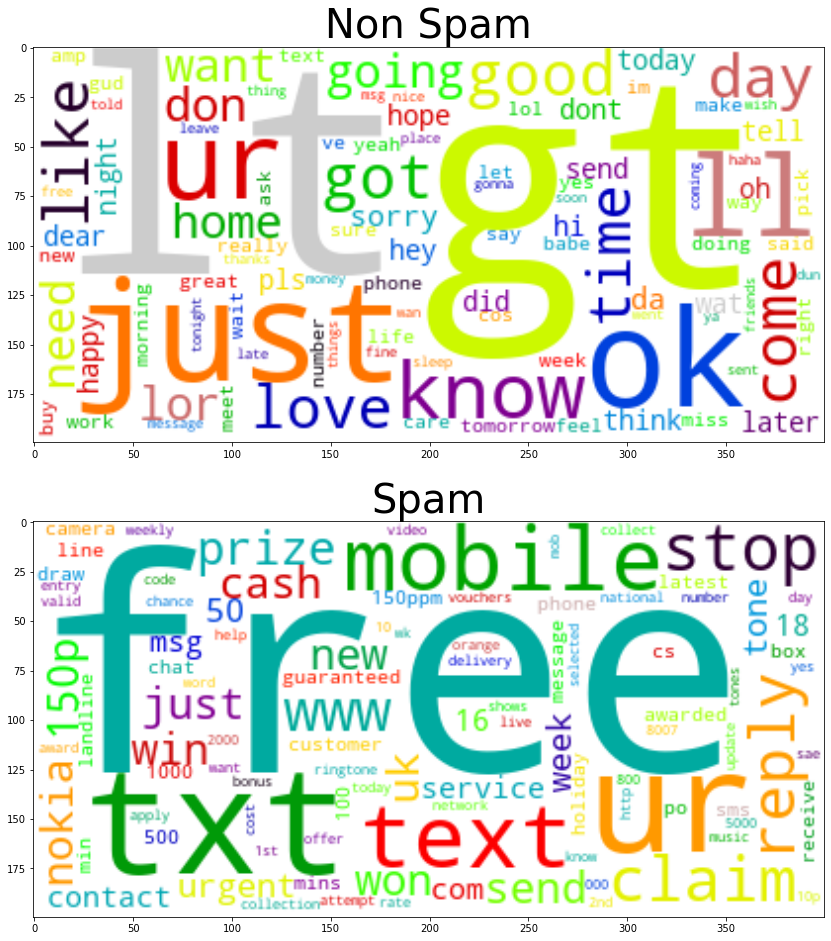

In [7]:
#making a word cloud for frequency in spam and ham messages
wc = WordCloud(stopwords=my_stop_words,
               background_color="white", colormap="nipy_spectral",
               max_font_size=150, random_state=12,
               max_words=100)

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,16))

wc.generate_from_frequencies(sum_mots['ham'])
ax1.imshow(wc, interpolation="bilinear")
ax1.set_title('Non Spam', fontdict={'size':40})

wc.generate_from_frequencies(sum_mots['spam'])
ax2.imshow(wc, interpolation="bilinear")
ax2.set_title('Spam', fontdict={'size':40});

In [8]:
#dtm_df has a lot of columns so updating

# removing those that account for less than 1% of occurances
part_occur = pd.DataFrame()
for i in ['ham','spam']:
    part_occur[i] = sum_mots[i]/len(dtm_df[dtm_df.index==i])

#getting the max share of part_occur
part_occur_max = part_occur.max(axis=1)

#adding stop-words to all words whose maximum share (between ham and spam) is less than 1%
sw_supp = part_occur_max[part_occur_max<=0.01].index
my_stop_words = ENGLISH_STOP_WORDS.union(sw_supp)

#redoing the matrix with new updated stop words
cv = CountVectorizer(stop_words=my_stop_words)
dtm = cv.fit_transform(df.sms_digits)
dtm_df = pd.DataFrame(dtm.toarray(),
                      columns=cv.get_feature_names_out(),
                      index=df.y)

In [17]:
#finding levels of subjectivity and positivity

pos = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

df['positivity'] = df.sms.apply(pos)
df['subjectivity'] = df.sms.apply(sub)
df.head()

,y,sms,sms_digits,sms_wo_digits,positivite,subjectivite,positivity,subjectivity
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only ...,go until jurong point crazy available only ...,0.15,0.7625,0.15,0.7625
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,ok lar joking wif u oni,0.50,0.5000,0.50,0.5000
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,free entry in a wkly comp to win fa cup final...,0.30,0.5500,0.30,0.5500
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,u dun say so early hor u c already then say,0.10,0.3000,0.10,0.3000
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives aro...,nah i don t think he goes to usf he lives aro...,0.00,0.0000,0.00,0.0000


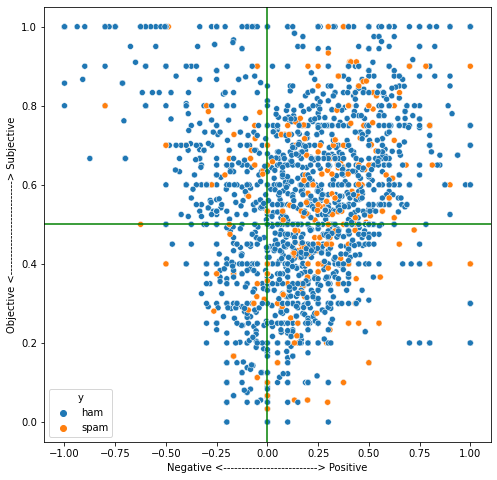

In [19]:
#plotting
plt.figure(figsize=(8,8))
sns.scatterplot(data=df, x='positivity', y='subjectivity', hue='y')
plt.axhline(y=0.5, color='g')
plt.axvline(x=0, color='g')
plt.xlabel("Negative <--------------------------> Positive")
plt.ylabel("Objective <--------------------------> Subjective");

In [20]:
#spam looks to be more positive, not much difference in subjectivness

In [21]:
# looking at the most positive non spam messages
df.loc[(df.positivite >= 0.95) & (df.y == 'ham'), 'sms'].values

array(['Great! I hope you like your man well endowed. I am  &lt;#&gt;  inches...',
       'Sounds great! Are you home now?',
       "Awesome, I'll see you in a bit", 'Bring home some Wendy =D',
       'Love it! Daddy will make you scream with pleasure! I am going to slap your ass with my dick!',
       'I am great! How are you?',
       'Macha dont feel upset.i can assume your mindset.believe me one evening with me and i have some wonderful plans for both of us.LET LIFE BEGIN AGAIN.call me anytime',
       'Lol! U drunkard! Just doing my hair at d moment. Yeah still up 4 tonight. Wats the plan? ',
       'Talk With Yourself Atleast Once In A Day...!!! Otherwise You Will Miss Your Best FRIEND In This WORLD...!!! -Shakespeare- SHESIL  &lt;#&gt;',
       "Awesome, lemme know whenever you're around",
       'Wat makes some people dearer is not just de happiness dat u feel when u meet them but de pain u feel when u miss dem!!!',
       'Awesome, think we can get an 8th at usf some time toni

In [23]:
#the least positive real messages
df.loc[(df.positivite <= -0.8) & (df.y == 'ham'), 'sms'].values

array(["We're all getting worried over here, derek and taylor have already assumed the worst",
       'Hey no I ad a crap nite was borin without ya 2 boggy with me u boring biatch! Thanx but u wait til nxt time il ave ya ',
       "Hasn't that been the pattern recently crap weekends?",
       "Annoying isn't it.",
       'Horrible gal. Me in sch doing some stuff. How come u got mc?',
       'Im in inperialmusic listening2the weirdest track ever by\x94leafcutter john\x94-sounds like insects being molested&someone plumbing,remixed by evil men on acid!',
       "Yeah jay's sort of a fucking retard",
       'Horrible bf... I now v hungry...',
       'Yes but i dont care! I need you bad, princess!',
       'The monthly amount is not that terrible and you will not pay anything till 6months after finishing school.',
       "I'm sick !! I'm needy !! I want you !! *pouts* *stomps feet* Where are you ?! *pouts* *stomps feet* I want my slave !! I want him now !!",
       'I might go 2 sch. Yar at

In [28]:
#most positive spam
df.loc[(df.positivite >= 0.8) & (df.y == 'spam'), 'sms'].values

array(['SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info',
       "For ur chance to win a £250 wkly shopping spree TXT: SHOP to 80878. T's&C's www.txt-2-shop.com custcare 08715705022, 1x150p/wk",
       'U are subscribed to the best Mobile Content Service in the UK for £3 per 10 days until you send STOP to 82324. Helpline 08706091795',
       'UR awarded a City Break and could WIN a £200 Summer Shopping spree every WK. Txt STORE to 88039 . SkilGme. TsCs087147403231Winawk!Age16 £1.50perWKsub',
       'all the lastest from Stereophonics, Marley, Dizzee Racal, Libertines and The Strokes! Win Nookii games with Flirt!! Click TheMob WAP Bookmark or text WAP to 82468',
       'EASTENDERS TV Quiz. What FLOWER does DOT compare herself to? D= VIOLET E= TULIP F= LILY txt D E or F to 84025 NOW 4 chance 2 WIN £100 Cash WKENT/150P16+',
       'For sale - arsenal dartboard. Good condition but no doubles or trebles

In [29]:
#most negative spam
df.loc[(df.positivite <= -0.8) & (df.y == 'spam'), 'sms'].values

array(['Filthy stories and GIRLS waiting for your',
       "Do you ever notice that when you're driving, anyone going slower than you is an idiot and everyone driving faster than you is a maniac?",
       "Rock yr chik. Get 100's of filthy films &XXX pics on yr phone now. rply FILTH to 69669. Saristar Ltd, E14 9YT 08701752560. 450p per 5 days. Stop2 cancel"],
      dtype=object)

In [30]:
#most subjective spam
df.loc[(df.subjectivite == 1) & (df.y == 'spam'), 'sms'].values

array(['WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.',
       'URGENT! Your Mobile No. was awarded £2000 Bonus Caller Prize on 5/9/03 This is our final try to contact U! Call from Landline 09064019788 BOX42WR29C, 150PPM',
       'Text & meet someone sexy today. U can find a date or even flirt its up to U. Join 4 just 10p. REPLY with NAME & AGE eg Sam 25. 18 -msg recd@thirtyeight pence',
       'URGENT! Your Mobile number has been awarded with a £2000 prize GUARANTEED. Call 09058094455 from land line. Claim 3030. Valid 12hrs only',
       'okmail: Dear Dave this is your final notice to collect your 4* Tenerife Holiday or #5000 CASH award! Call 09061743806 from landline. TCs SAE Box326 CW25WX 150ppm',
       "+123 Congratulations - in this week's competition draw u have won the £1450 prize to claim just call 09050002311 b4280703. T&Cs/stop SMS 08718727868. Over 18 only 150ppm"

In [27]:
#seeing if it thinks of "lol" as positive
print(f'lol = {TextBlob("lol").sentiment}')

#seeing sentiment rankings for emojis
for smiley in ":) :( :-p :/ ;) ^^ :k \o/ :D :o".split():
    print(f"{smiley} = {TextBlob(smiley).sentiment}")

lol = Sentiment(polarity=0.8, subjectivity=0.7)
:) = Sentiment(polarity=0.5, subjectivity=1.0)
:( = Sentiment(polarity=-0.75, subjectivity=1.0)
:-p = Sentiment(polarity=0.75, subjectivity=1.0)
:/ = Sentiment(polarity=-0.25, subjectivity=1.0)
;) = Sentiment(polarity=0.25, subjectivity=1.0)
^^ = Sentiment(polarity=0.0, subjectivity=0.0)
:k = Sentiment(polarity=0.0, subjectivity=0.0)
\o/ = Sentiment(polarity=0.0, subjectivity=0.0)
:D = Sentiment(polarity=1.0, subjectivity=1.0)
:o = Sentiment(polarity=0.05, subjectivity=1.0)


In [31]:
#adding positivity and subjectivity to the matrix
dtm_df[['positivity', 'subjectivity']] = df[['positivity', 'subjectivity']].values

On training set : 0.9971794871794872, on test set : 0.9760765550239234


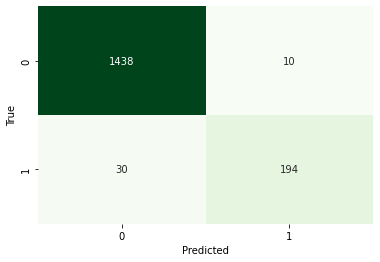

In [34]:
#train test split
y = 1 * (dtm_df.index == 'spam')
X_train, X_test, y_train, y_test = train_test_split(dtm_df, y, test_size=0.3, stratify=y)

#training random forest 
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train.drop(['positivity', 'subjectivity'],axis=1), y_train)
print(f"On training set : {rf.score(X_train.drop(['positivity', 'subjectivity'],axis=1), y_train)}, on test set : {rf.score(X_test.drop(['positivity', 'subjectivity'],axis=1), y_test)}")

#confusion matrix
sns.heatmap(confusion_matrix(y_test, rf.predict(X_test.drop(['positivity', 'subjectivity'],axis=1))), annot=True, cbar=False, fmt='d', cmap="Greens")
plt.ylabel('True')
plt.xlabel('Predicted');